# *Manufacturing Root Cause (Group 3)*

Project members:
- Amine Amri
- Julia Graham
- Sebastian Anusch
- Simone Assirelli 

****************************************************************************************************************************************

Key tasks & decisions by Wednesday April 3rd (Q&A)::
- [X] Missing values (drop or impute?) 
- [X] Address outliers 
- [X] Data normalization (standard scaler)
- [X] Feature reduction/selection 
- [X] Merge defects columns 
- [X] Prepare PPT 
- [X] Deal with data leakage

Key tasks & decisions by final session Thursday April 18th:
- [X] About feature selection: try with keeping only 10 features and see what happens
- [X] Train a **Random Forest classifier** with train, _validation_ (!) and test split
- [X] Train a **XGBOOST classifier** with train, validation and test split
- [X] Train a **Logistic Regression classifier** with train, validation and test split
- [ ] For each of these classifiers, use **GridSearchCV**  to find the best parameters maximising accuracy 
- [X] Try with 45 features 

Key questions:
- How can we  improve our model?
-  How can we interpret the results and see which features are most important to detect the defect (what the company really cares about)?

In [47]:
!pip install xgboost

In [1]:
import pandas as pd
import  numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import accuracy_score


# 1. Data Preparation

In [2]:
url_defects = 'https://dl.dropboxusercontent.com/scl/fi/j3xred1cqmicuxui4kj6m/RC_DEFECTS_clean.csv?rlkey=gumwpqnsfvdyjdx5doi4i7zxb&dl=1'
url_production = 'https://dl.dropboxusercontent.com/scl/fi/baekmodofe2sn64qhrcur/RC_PRODUCTION_clean.csv?rlkey=uw7r9vgblez57cbnwsf2c3vmd&dl=1'
df_def = pd.read_csv(url_defects)
df_prod = pd.read_csv(url_production)

### Exploring the data

In [3]:
print(df_def.shape)
df_def.head()

(617, 10)


,COIL,MT_FROM,MT_TO,DATE,DIF_TIPO_1,DIF_TIPO_2,DIF_TIPO_3,DIF_TIPO_4,DIF_TIPO_5,DIF_TIPO_6
0,389523,0.0,599.0,2019-03-01,0,0,1,0,0,0
1,389523,600.0,1457.0,2019-03-01,0,1,1,0,0,0
2,389528,0.0,1399.0,2019-03-01,0,0,1,0,0,0
3,389528,1400.0,1539.0,2019-03-01,0,0,1,0,1,0
4,389712,0.0,1374.0,2019-03-01,0,0,1,0,0,0


In [4]:
print(df_prod.shape)
df_prod.head()

(299384, 110)


,COIL,DATE,MT,TIME_START_PROCESS,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,...,SPZ2_R4,SPZ1_R1_ASS,SPZ1_R2_ASS,TIRO_DECAP,SPEED_FILL,FILL_FORZA,FILL_TIRO,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG
0,240627,2019-03-15,0.0,14:25:23.060,16.934625,671.967562,679.751438,688.119187,716.717250,734.616563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,240627,2019-03-15,7.0,14:25:53.060,16.773638,668.635875,676.207125,681.034500,710.093250,729.040500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,240627,2019-03-15,14.0,14:26:23.060,11.142165,669.105375,677.042625,678.493125,707.967750,727.783500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,240627,2019-03-15,21.0,14:27:08.060,11.148851,671.631750,681.066000,679.704750,707.241375,727.886250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,240627,2019-03-15,28.0,14:27:38.060,15.657188,675.052875,686.972813,683.336250,710.432437,730.182375,...,530.110125,14.625,14.625,1956.40875,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Columns of production dataframe
prod_columns = list(df_prod.columns)
print(prod_columns) 

['COIL', 'DATE', 'MT', 'TIME_START_PROCESS', 'SPEED_PROCESS', 'TEMP_Z1', 'TEMP_Z2', 'TEMP_Z3', 'TEMP_Z4', 'TEMP_Z5', 'TEMP_Z6', 'PYRO_1_PRECHMBR', 'PYRO_2_FRST_3_ZONE', 'PYRO_3_LST_3_ZONE', 'LS_OVEN', 'LASER_FRN_1', 'LASER_FRN_2', 'LASER_FRN_3', 'LASER_FRN_4', 'LASER_FRN_5', 'LASER_FRN_6', 'LASER_FRN_7', 'LASER_FRN_8', 'LASER_FRN_9', 'AIR_CH4_1', 'AIR_CH4_2', 'AIR_CH4_3', 'AIR_CH4_4', 'AIR_CH4_5', 'AIR_CH4_6', 'AIR_Z1_1', 'AIR_Z1_2', 'AIR_Z2_1', 'AIR_Z2_2', 'AIR_Z3_1', 'AIR_Z3_2', 'AIR_Z4_1', 'AIR_Z4_2', 'AIR_Z5_1', 'AIR_Z5_2', 'AIR_Z6_1', 'AIR_Z6_2', 'GAS_Z1_1', 'GAS_Z1_2', 'GAS_Z2_1', 'GAS_Z2_2', 'GAS_Z3_1', 'GAS_Z3_2', 'GAS_Z4_1', 'GAS_Z4_2', 'GAS_Z5_1', 'GAS_Z5_2', 'GAS_Z6_1', 'GAS_Z6_2', 'FRN_PHF_PRESSURE', 'FRN_FURNACE_PRESSURE', 'TIRO_FORNO', 'PRES_ZONA1_MEASURED', 'PRES_ZONA1_SET', 'PRES_ZONA2_MEASURED', 'PRES_ZONA2_SET', 'PRES_ZONA3_MEASURED', 'PRES_ZONA3_SET', 'EXT_1', 'EXT_2', 'VENT_1', 'VENT_2', 'VENT_3', 'VENT_4', 'VENT_5', 'COOL_1A', 'COOL_1B', 'COOL_2A', 'COOL_2B', 'COOL

In [6]:
df_prod.describe()

,COIL,MT,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,TEMP_Z6,PYRO_1_PRECHMBR,...,SPZ2_R4,SPZ1_R1_ASS,SPZ1_R2_ASS,TIRO_DECAP,SPEED_FILL,FILL_FORZA,FILL_TIRO,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG
count,2.993840e+05,299384.000000,299384.000000,299384.000000,299384.000000,299384.000000,299384.000000,299384.000000,299384.000000,299384.000000,...,283737.000000,283737.000000,283737.000000,283737.000000,270904.000000,270904.000000,270904.000000,270904.000000,270904.000000,270904.000000
mean,4.210808e+05,1013.750454,36.030174,1236.378668,1257.600788,1266.031784,1279.476562,1293.618170,1281.422092,802.675699,...,526.644078,18.292673,18.344328,3186.598116,39.900765,689.840763,3610.710095,0.532809,0.164599,0.169975
std,2.484114e+05,874.832131,11.243607,87.092407,87.833443,87.717798,85.313536,88.576110,84.233837,38.910802,...,34.108621,2.699142,2.794101,1306.570596,17.267686,279.623230,982.734142,0.232301,0.040681,0.038671
min,2.406270e+05,0.000000,-2.304028,79.722742,74.225453,74.198610,77.426415,78.567278,79.205925,549.382500,...,-3.665034,0.000000,0.000000,856.680000,-1.809788,-496.040375,-48.285825,0.000000,-0.011853,-0.016642
25%,3.947170e+05,378.000000,28.063851,1236.605625,1259.813250,1271.021625,1260.090000,1261.445625,1271.056781,795.292844,...,529.919898,16.875000,16.875000,2333.722500,28.351013,496.627351,2946.052969,0.470936,0.134999,0.135002
50%,4.037420e+05,812.000000,33.685521,1261.473750,1272.760476,1278.000540,1286.188125,1317.151607,1293.406875,811.525114,...,530.125500,18.000000,18.000000,2901.962812,37.656312,662.102578,3790.602141,0.559548,0.135037,0.161994
75%,4.146100e+05,1400.000000,44.908965,1270.924798,1293.924375,1303.419825,1316.148750,1333.189687,1313.704765,823.938673,...,530.315100,20.248013,20.250000,4021.551000,49.828513,837.825196,4217.453156,0.572413,0.188993,0.189022
max,6.838679e+06,7273.000000,67.408785,1322.268750,1344.982500,1357.508250,1348.341750,1367.288438,1362.536250,931.753875,...,541.123650,31.405500,32.747692,9073.901250,90.010696,2933.876250,6257.584687,7.342893,0.679614,0.324028


Mean of TEMP_Z1

In [11]:
df_prod['TEMP_Z1'].mean()

1236.3786679913394

In [7]:
# How many unique coils are there in the defects dataframe?
unique_coils_count_0 = df_def['COIL'].nunique()
print(f"In 'df_def' dataframe there are {unique_coils_count_0} unique COIL values.")

In 'df_def' dataframe there are 534 unique COIL values.


In [8]:
# How many unique coils are there in the production dataframe?
unique_coils_count_1 = df_prod['COIL'].nunique()
print(f"In 'df_def' dataframe there are {unique_coils_count_1} unique COIL values.")

In 'df_def' dataframe there are 1261 unique COIL values.


In [9]:
subset_columns = ['COIL', 'MT_FROM', 'MT_TO', 'DATE']

#Check for duplicates in the first DataFrame
duplicates_df_def = df_def[df_def.duplicated(subset=subset_columns, keep=False)]


# Display the duplicates, if any, in each DataFrame
if not duplicates_df_def.empty:
    print("Duplicates found in df_def:")
    print(duplicates_df_def)
else:
    print("No duplicates found in 'df_def'")

No duplicates found in 'df_def'


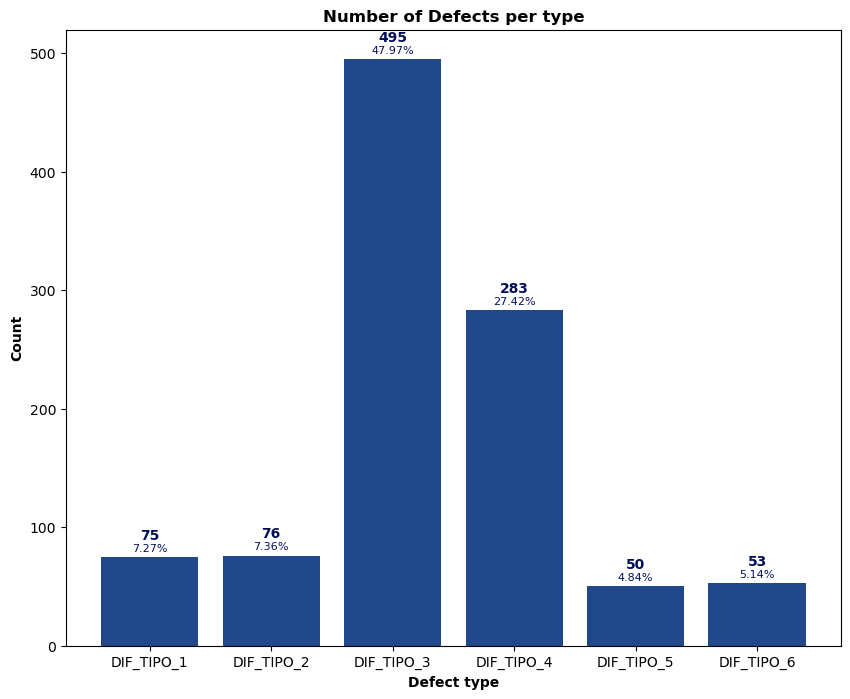

In [10]:
counts = df_def.iloc[:, 4:10].eq(1).sum()

# Calculate total count
total_count = counts.sum()

# Calculate percentage for each count
percentages = (counts / total_count) * 100

# Create a figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the counts using a bar chart with the specified color and font
bars = ax.bar(counts.index, counts.values, color='#21488A')
plt.bar(counts.index, counts.values, color='#21488A')
plt.title('Number of Defects per type', fontweight='bold')
plt.xlabel('Defect type', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

for bar, count, percent in zip(bars, counts, percentages):
    ax.text(bar.get_x() + bar.get_width() / 2, count + 15, str(count), ha='center', fontweight='bold', color='#010F59')
    ax.text(bar.get_x() + bar.get_width() / 2, count + 5, f'{percent:.2f}%', ha='center', color='#010F59', fontsize='8')


plt.show()

### Adjusting the 'MT' column
Since there are inconsistencies along the 'MT' column, i.e. there are coils with an inconsistent sequence of meters, we addressed this problem by creating a new variable 'MT_ADJUSTED' that ensures a correct sequence of meters (one observation every 7 meters)

In [58]:
df_prod.sort_values(['COIL', 'DATE', 'TIME_START_PROCESS'], inplace=True)
df_prod['MT_ADJUSTED'] = df_prod.groupby(['COIL'])['MT'] \
                          .transform(lambda x: np.arange(0., len(x) * 7, 7.))
df_prod.drop('MT', axis=1, inplace=True)

### Merging process

Attaching production information only over coils with defects

In [59]:
merged_defects = df_prod.merge(df_def, on=['COIL', 'DATE'], how='inner') # By doing so you obtain only the 
                                                                         # observations with defects
print("Shape before dropping duplicates and unnecessary columns: {}", merged_defects.shape)

merged_defects = merged_defects[(merged_defects['MT_ADJUSTED'] >= merged_defects['MT_FROM']) & 
                      (merged_defects['MT_ADJUSTED'] < merged_defects['MT_TO'])] # This filtering is needed as you 
                                                                                 # want to specify that 
                                                                                 # 'MT_ADJUSTED' must be be found 
                                                                                 # inside the defect range 
merged_defects.drop_duplicates(['COIL', 'DATE', 'MT_ADJUSTED'], inplace=True)
merged_defects.drop(['MT_FROM', 'MT_TO'], axis=1, inplace=True)
print("Shape after dropping duplicates and unnecessary columns: {}", merged_defects.shape)

Shape before dropping duplicates and unnecessary columns: {} (131179, 118)
Shape after dropping duplicates and unnecessary columns: {} (106075, 116)


In [60]:
lst_col_labels = ['COIL', 'DATE', 'MT_ADJUSTED']+[i for i in merged_defects.columns if 'DIF_TIPO' in i]
merged_defects = merged_defects[lst_col_labels]
merged_final = df_prod.merge(merged_defects, on = ['COIL', 'DATE', 'MT_ADJUSTED'], how='left')
merged_final.head()

,COIL,DATE,TIME_START_PROCESS,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,TEMP_Z6,...,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG,MT_ADJUSTED,DIF_TIPO_1,DIF_TIPO_2,DIF_TIPO_3,DIF_TIPO_4,DIF_TIPO_5,DIF_TIPO_6
0,240627,2019-03-15,14:25:23.060,16.934625,671.967562,679.751438,688.119187,716.717250,734.616563,734.603062,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,240627,2019-03-15,14:25:53.060,16.773638,668.635875,676.207125,681.034500,710.093250,729.040500,727.025625,...,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2,240627,2019-03-15,14:26:23.060,11.142165,669.105375,677.042625,678.493125,707.967750,727.783500,724.035750,...,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN
3,240627,2019-03-15,14:27:08.060,11.148851,671.631750,681.066000,679.704750,707.241375,727.886250,723.072375,...,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN
4,240627,2019-03-15,14:27:38.060,15.657188,675.052875,686.972813,683.336250,710.432437,730.182375,724.168688,...,NaN,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
merged_final.shape

(299384, 116)

After this process, 'merged_final' contains the production data with defect information correctly applied. Each row in 'merged_final' represents production data, and if there were any defects associated with the particular meter range of a coil, this information is now included in the corresponding rows.

Downloading the merged data in a csv format (in case you want to visualize it on Excel) \
P.S. Do not run this if you don't want to download it!

### Dealing with Missing Values

Question: Are there missing values in the ['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6'] columns?

In [63]:
merged_final[['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 
           'DIF_TIPO_5', 'DIF_TIPO_6']].isna().sum()

DIF_TIPO_1    193309
DIF_TIPO_2    193309
DIF_TIPO_3    193309
DIF_TIPO_4    193309
DIF_TIPO_5    193309
DIF_TIPO_6    193309
dtype: int64

Answer: Yes. Therefore, we need to convern Null values to 0s for observations that have no defects

In [64]:
# List of defect columns - replace or extend this with your actual defect column names
defect_columns = ['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6']

# Replace NaN values with 0 in defect columns
for col in defect_columns:
    merged_final[col] = merged_final[col].fillna(0)

merged_final[['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 
           'DIF_TIPO_5', 'DIF_TIPO_6']].isna().sum()

DIF_TIPO_1    0
DIF_TIPO_2    0
DIF_TIPO_3    0
DIF_TIPO_4    0
DIF_TIPO_5    0
DIF_TIPO_6    0
dtype: int64

In [65]:
# Checking overall missing values
merged_final.isna().sum().sum()

908899

Let's visualize missing values with a bar chart

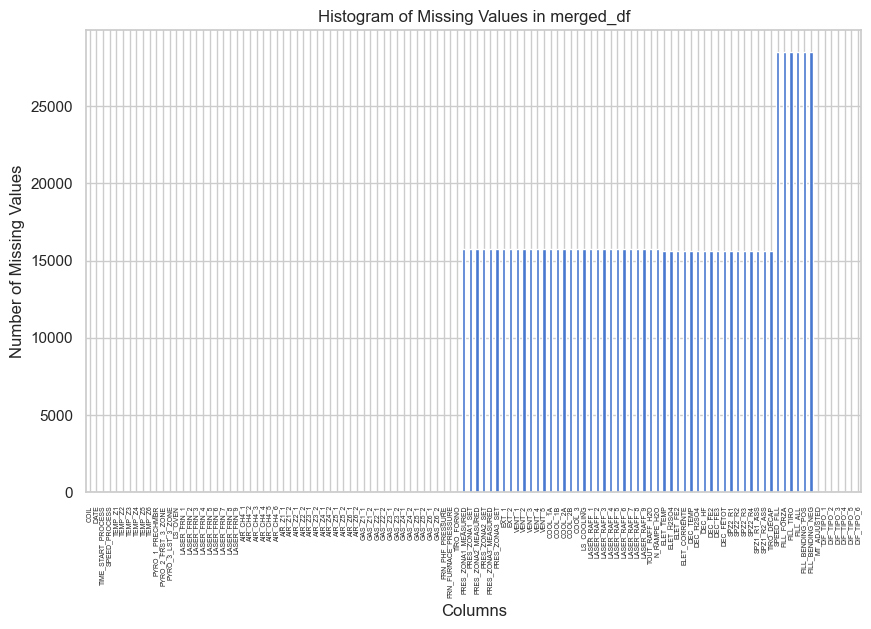

In [66]:
missing_values = merged_final.isna().sum()

plt.figure(figsize=(10, 6))
missing_values.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Histogram of Missing Values in merged_df')
plt.xticks(rotation=90, fontsize = 5)
plt.show()

In order to deal with the missing values, we decided to procceed with imputing the mean of each column, since the loss of information deriving from the elimination of columns would be too significant

In [67]:
for column in merged_final.columns:
    # Check if the column is numeric (float or int)
    if pd.api.types.is_numeric_dtype(merged_final[column]):
        # Calculate the mean of the current column, skipping NaN values
        mean_value = merged_final[column].mean()
        
        # Replace NaNs in the column with the mean value
        merged_final[column].fillna(mean_value, inplace=True)

In [68]:
# Checking overall missing values
print(f'After imputation we end up with {merged_final.isna().sum().sum()} missing values in the dataset')

After imputation we end up with 0 missing values in the dataset


###  Dealing with Outliers

Let's first identify the outliers by considering those values that fall outside of the 1st and 99th percentile range

In [69]:
def get_outlier_indices(merged_final, column):
    q1 = merged_final[column].quantile(0.01)
    q3 = merged_final[column].quantile(0.99)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = merged_final[(merged_final[column] < lower_bound) | (merged_final[column] > upper_bound)]
    return outliers.index

# List of columns to exclude from outlier detection
columns_to_exclude = ['COIL', 'DATE', 'TIME_START_PROCESS']  

# Get a list of all outlier indices, excluding the specified columns
outlier_indices = []
for column in merged_final.columns:
    if column not in columns_to_exclude and pd.api.types.is_numeric_dtype(merged_final[column]):
        outlier_indices.extend(get_outlier_indices(merged_final, column))

# How many outliers does our dataset contain?
num_outliers = len(outlier_indices)
print("Number of outliers found: ", num_outliers)


Number of outliers found:  23402


In [70]:
def get_top_outliers(merged_final, n=5, exclude=None):
    if exclude is None:
        exclude = []
    outlier_counts = {}
    for column in merged_final.columns:
        if column not in exclude and pd.api.types.is_numeric_dtype(merged_final[column]):
            outlier_indices = get_outlier_indices(merged_final, column)
            outlier_counts[column] = len(outlier_indices)
    sorted_outliers = sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_outliers[:n]

# Exclude 'COIL' and any other columns you don't want to include
exclude_columns = ['COIL', 'DATE', 'TIME_START_PROCESS']
# Get the top 5 columns with the most outliers excluding the 'COIL' column
print("Top 5 columns with the most outliers excluding 'COIL':")
for col, count in get_top_outliers(merged_final, 5, exclude=exclude_columns):
    print(f"{col}: {count} outliers")


Top 5 columns with the most outliers excluding 'COIL':
N_RAMPE_H2O: 2731 outliers
AIR_CH4_3: 2185 outliers
AIR_CH4_2: 2099 outliers
ELET_TEMP: 1530 outliers
AIR_CH4_6: 1399 outliers


d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

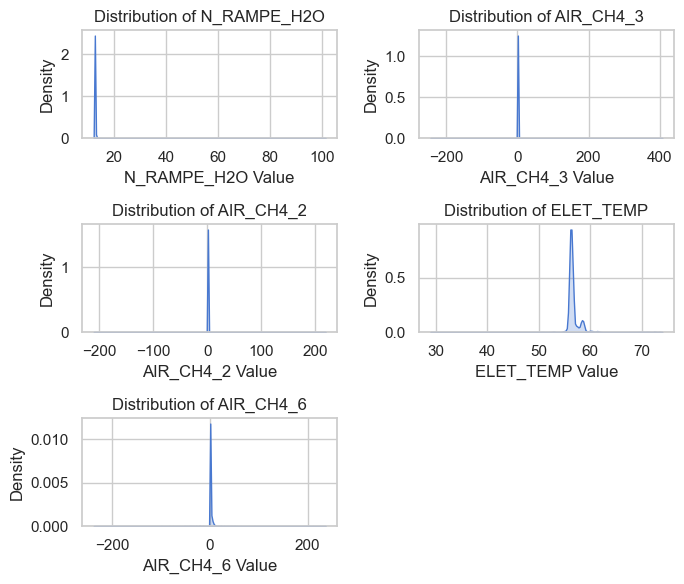

In [71]:
# The list of top columns with the most outliers, replace with your actual column names
top_features = ['N_RAMPE_H2O', 'AIR_CH4_3', 'AIR_CH4_2', 'ELET_TEMP', 'AIR_CH4_6'] # for example

# Set the aesthetics for the plots
sns.set(style='whitegrid', palette='muted')

# Determine the layout size
num_plots = len(top_features)
ncols = 2  # You can adjust this based on your preference and screen size
nrows = num_plots // ncols + (num_plots % ncols > 0)

# Create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7, 2 * nrows))

# Flatten the axes array for easy iteration if there are more than one row
if nrows > 1:
    axes = axes.flatten()
else:
    axes = [axes]

# Plot the distribution of each feature
for ax, feature in zip(axes, top_features):
    sns.kdeplot(data=merged_final, x=feature, ax=ax, fill=True)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(f'{feature} Value')
    ax.set_ylabel('Density')

# Hide any unused subplots
for i in range(len(top_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

From the shape of these distributions, particularly the sharp peaks, it seems likely that these variables have many recurring standard values with sporadic deviations. This could be characteristic of sensor readings where a 'normal' condition is represented by a constant reading and deviations from this might be indicative of certain events or conditions of interest (potentially defects in the context of your work).

In [72]:
# I want to know how many outliers have a defect or not
outliers_with_defect = merged_final.loc[outlier_indices, 'DIF_TIPO_1':'DIF_TIPO_6'].sum(axis=1) > 0
print(outliers_with_defect.sum(), "outliers have at least one defect")

# I want to know how many outliers don't have a defect
outliers_without_defect = merged_final.loc[outlier_indices, 'DIF_TIPO_1':'DIF_TIPO_6'].sum(axis=1) == 0
print(outliers_without_defect.sum(), "outliers don't have any defect")

6138 outliers have at least one defect
17264 outliers don't have any defect


For the reason explained above, we decided to not drop any outlier since it could be essential for the determination of the defects

# 2. Data Preprocessing

Columns ranges

In [73]:
# Initialize lists to store the data
column_names = []
min_values = []
max_values = []

# Iterate through each column in the DataFrame
for column in merged_final.columns[3:]:
    column_names.append(column)
    min_values.append(merged_final[column].min())
    max_values.append(merged_final[column].max())

# Create a new DataFrame with the summary information
ranges_df = pd.DataFrame({'Column Name': column_names, 'Minimum Value': min_values, 'Maximum Value': max_values})

ranges_df.head(5)


,Column Name,Minimum Value,Maximum Value
0,SPEED_PROCESS,-2.304028,67.408785
1,TEMP_Z1,79.722742,1322.268750
2,TEMP_Z2,74.225453,1344.982500
3,TEMP_Z3,74.198610,1357.508250
4,TEMP_Z4,77.426415,1348.341750


We wanted to check whether our columns values had different ranges. By exploring the dataframe above we can safely state that it is the case, therefore we could consider scaling the data

### Normalization

In [74]:
# Create a StandardScaler object
scaler = StandardScaler()

# List of defect columns to exclude
defect_columns = ['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6']

# Select all numeric columns
numeric_cols = merged_final.select_dtypes(include=[np.number]).columns

# Filter out the defect columns
numeric_cols = [col for col in numeric_cols if col not in defect_columns if col not in ['COIL', 'MT_ADJUSTED']]

merged_final[numeric_cols] = scaler.fit_transform(merged_final[numeric_cols])

**'df_cleaned'** now contains normalized data

### Merging the defects columns

In [75]:
# Create a new column 'Has_Defect' which is 1 if any of 'DIF_TIPO_X' columns are 1, otherwise 0
merged_final['Has_Defect'] = merged_final[defect_columns].max(axis=1)

# Now df['Has_Defect'] is 1 for rows where there's at least one defect, and 0 where there are none

C:\Users\simon\AppData\Local\Temp\ipykernel_16124\105595664.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_final['Has_Defect'] = merged_final[defect_columns].max(axis=1)


**'df_new'** now contains data with the binary variable 'Has_Defect'

In [76]:
# Count the values of the 'Has_Defect' column
defect_counts = merged_final['Has_Defect'].value_counts()
print(f"The number of records that have at least 1 defect is {defect_counts[1]}")

The number of records that have at least 1 defect is 106075


### Distribution of defects

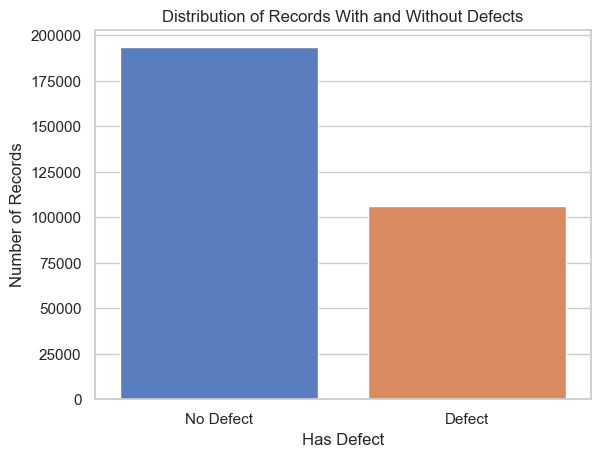

In [77]:
# Looking at the distribution of defects
sns.barplot(x=defect_counts.index, y=defect_counts.values, palette="muted")

# Set the labels and title
plt.xlabel('Has Defect')
plt.ylabel('Number of Records')
plt.title('Distribution of Records With and Without Defects')
plt.xticks([0, 1], ['No Defect', 'Defect'])  # Replace with [1, 0] if 1 represents 'Defect'

# Show the plot
plt.show()

Here above we can see a clear imbalance between the two classes

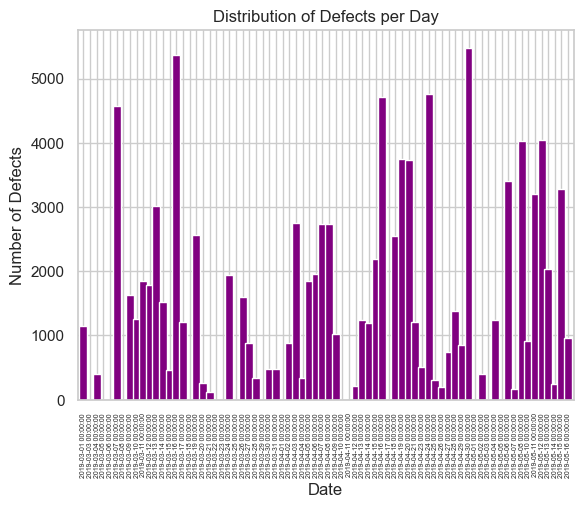

In [94]:
# Ensure the date column is in datetime format
merged_final['DATE'] = pd.to_datetime(merged_final['DATE'])

# If you have a binary 'defect' column, use sum. If not, adjust this step accordingly.
defects_per_day = merged_final.groupby('DATE')['Has_Defect'].sum()

# Plot the distribution
defects_per_day.plot(kind='bar', width=1.2, color='purple') # or 'line', depending on your preference
plt.title('Distribution of Defects per Day')
plt.xlabel('Date')
plt.ylabel('Number of Defects')
plt.xticks(rotation=90, fontsize = 5)
plt.show()

## Feature Selection

### Feature reduction using Correlation

The number of features is definetely too high. We should approach this problem by eliminating  redundant or irrelevant information, and focusing on the most important features that contribute to our target variable. 
We followed a simple strategy, i.e. we set a threshold for correlation (0.65) and deleted the features whose correlation exceeded this threshold.

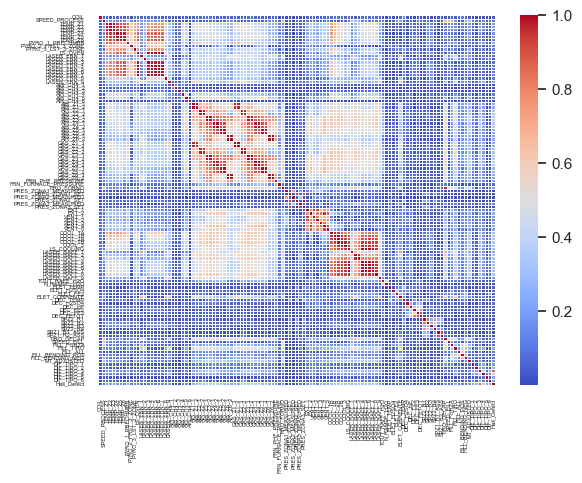

In [95]:
# Select only numeric data
numeric_data = merged_final.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_data.corr().abs()

sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns,
            cmap='coolwarm',  # Choose a colormap that fits your needs
            annot=False,      # Add annotation to each cell
            linewidths=.5,   # Add lines between cells
            fmt=".2f")       # Format for the annotation

plt.tick_params(axis='x', which='major', labelsize=4)
plt.tick_params(axis='y', which='major', labelsize=4)
# Show the plot
plt.show()

You can clearly see some regions where features are correlated with each other, so we have to take care of that

In [96]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

# Drop highly correlated features
df_reduced = merged_final.drop(to_drop, axis=1)

print(f"'df_reduced' now contains {df_reduced.shape[0]} rows and {df_reduced.shape[1]} columns")


'df_reduced' now contains 299384 rows and 50 columns


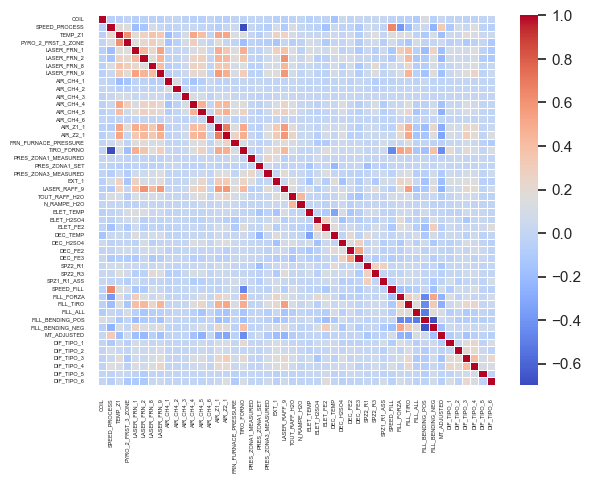

In [97]:
# Select only numeric data
numeric_data_reduced = df_reduced.select_dtypes(include=[np.number])
corr = numeric_data_reduced.corr()

sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='coolwarm',  # Choose a colormap that fits your needs
            annot=False,      # Add annotation to each cell
            linewidths=.5,   # Add lines between cells
            fmt=".2f")       # Format for the annotation

plt.tick_params(axis='x', which='major', labelsize=4)
plt.tick_params(axis='y', which='major', labelsize=4)
# Show the plot
plt.show()

Add 'Has_Defect again'

In [99]:
# Create a new column 'Has_Defect' which is 1 if any of 'DIF_TIPO_X' columns are 1, otherwise 0
df_reduced['Has_Defect'] = df_reduced[defect_columns].max(axis=1)

In [100]:
prod_columns = list(df_reduced.columns)
print(prod_columns) 

['COIL', 'DATE', 'TIME_START_PROCESS', 'SPEED_PROCESS', 'TEMP_Z1', 'PYRO_2_FRST_3_ZONE', 'LASER_FRN_1', 'LASER_FRN_2', 'LASER_FRN_8', 'LASER_FRN_9', 'AIR_CH4_1', 'AIR_CH4_2', 'AIR_CH4_3', 'AIR_CH4_4', 'AIR_CH4_5', 'AIR_CH4_6', 'AIR_Z1_1', 'AIR_Z2_1', 'FRN_FURNACE_PRESSURE', 'TIRO_FORNO', 'PRES_ZONA1_MEASURED', 'PRES_ZONA1_SET', 'PRES_ZONA3_MEASURED', 'EXT_1', 'LASER_RAFF_9', 'TOUT_RAFF_H2O', 'N_RAMPE_H2O', 'ELET_TEMP', 'ELET_H2SO4', 'ELET_FE2', 'DEC_TEMP', 'DEC_H2SO4', 'DEC_FE2', 'DEC_FE3', 'SPZ2_R1', 'SPZ2_R3', 'SPZ1_R1_ASS', 'SPEED_FILL', 'FILL_FORZA', 'FILL_TIRO', 'FILL_ALL', 'FILL_BENDING_POS', 'FILL_BENDING_NEG', 'MT_ADJUSTED', 'DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6', 'Has_Defect']


### Feature Importance with Random Forest

In [83]:
# target = "Has_Defect"
# X = df_reduced.drop(['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS', target], axis=1)
# y = df_new[target]

In [84]:
# # Split the dataset into a training set and a test set
# train_size = 0.6
# random_state = 42
# Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = train_size, random_state = random_state)
# print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

In [85]:
# # Initialize and train a Random Forest classifier
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_classifier.fit(Xtrain, ytrain)

# # Obtain feature importances from the trained Random Forest classifier
# feature_importances = rf_classifier.feature_importances_

# # Rank features by importance
# feature_importance_ranking = np.argsort(feature_importances)[::-1]

# # Print the ranked features along with their names
# print("Feature Ranking:")
# for rank, feature_idx in enumerate(feature_importance_ranking):
#     print(f"Rank {rank + 1}: Feature '{Xtrain.columns[feature_idx]}' - Importance Score: {feature_importances[feature_idx]}")

In [86]:
# #Specify the number of top features to keep
# num_top_features = 40

# # Select the top-ranked features
# selected_feature_indices = feature_importance_ranking[:num_top_features]
# selected_feature_names = [Xtrain.columns[idx] for idx in selected_feature_indices]

# # Print the selected top features
# print("Selected Top Features:")
# for feature_name in selected_feature_names:
#     print(feature_name)

In [87]:
# plt.figure()
# plt.title("Feature importances")
# plt.bar(range(Xtrain.shape[1]), feature_importances[feature_importance_ranking],
#        color="r", align="center")
# plt.xticks(range(Xtrain.shape[1]), Xtrain.columns[feature_importance_ranking], rotation=90)
# plt.xlim([-1, Xtrain.shape[1]])
# plt.show()

# 3. Modeling  

In [88]:
# # Recreate the original dataframe with much less features
# selected_feature_names_original = ['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS'] + selected_feature_names + ['Has_Defect']
# df_final = df_new[selected_feature_names_original]
# df_final.shape


Download 'df_final' as csv file

In [101]:
df_reduced.to_csv('final_all_defects.csv', index=False)

In [90]:
df_reduced.head()

,COIL,DATE,TIME_START_PROCESS,SPEED_PROCESS,TEMP_Z1,PYRO_2_FRST_3_ZONE,LASER_FRN_1,LASER_FRN_2,LASER_FRN_8,LASER_FRN_9,...,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG,MT_ADJUSTED,DIF_TIPO_1,DIF_TIPO_2,DIF_TIPO_3,DIF_TIPO_4,DIF_TIPO_5,DIF_TIPO_6
0,240627,2019-03-15,14:25:23.060,-1.698350,-6.480611,-6.260562,-1.108191,-2.389473,-3.811867,-2.455160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,240627,2019-03-15,14:25:53.060,-1.712668,-6.518866,-6.253058,-1.108199,-2.376155,-3.795318,-2.455455,...,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
2,240627,2019-03-15,14:26:23.060,-2.213529,-6.513475,-6.261373,-1.108177,-2.369908,-3.783512,-2.455522,...,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0
3,240627,2019-03-15,14:27:08.060,-2.212934,-6.484467,-6.161300,-1.108188,-2.340920,-3.760286,-2.455393,...,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0
4,240627,2019-03-15,14:27:38.060,-1.811965,-6.445186,-5.887232,-1.108134,-2.305111,-3.712663,-2.454928,...,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0


**'df_final'** is now our final dataframe with the selected features and the target column of interest ('Has_Defect') at the end

#### Splitting our data into Train, Validation and Test sets

To ensure that the same coils are not split across both the training and testing sets, thereby preventing data leakage, we need to stratify the split based on the coil ID. This means we should split our dataset in such a way that all records belonging to a specific coil are either entirely in the training set or entirely in the testing set

In [91]:
# Get unique coil IDs and split them
unique_coils = df_reduced['COIL'].unique()
train_coils, test_coils = train_test_split(unique_coils, test_size=0.2, random_state=42)
train_coils, val_coils = train_test_split(train_coils, test_size=0.25, random_state=42)  # Splitting the remaining 80% into 60% train and 20% validation

# Split the DataFrame into training, validation, and testing sets based on coil IDs
train_df = df_reduced[df_reduced['COIL'].isin(train_coils)]
val_df = df_reduced[df_reduced['COIL'].isin(val_coils)]
test_df = df_reduced[df_reduced['COIL'].isin(test_coils)]


In [92]:
target = "Has_Defect"

# Prepare the data
X_train = train_df.drop(['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS', target], axis=1)  
y_train = train_df[target]    

X_val = val_df.drop(['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS', target], axis=1)
y_val = val_df[target]

X_test = test_df.drop(['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS', target], axis=1)   
y_test = test_df[target]     

KeyError: "['Has_Defect'] not found in axis"

### Random Forest 

Optimized Hyperparameter Tuning for Random Forest Classifier with Reduced Computational Complexity

In [ ]:
# # Initialize the classifier
# rf_clf = RandomForestClassifier(random_state=42)

# param_grid = {
#     'n_estimators': [100],  # Keeping one option to reduce combinations
#     'max_depth': [10, None],  # A reasonable depth, and None for fully grown trees
#     'min_samples_split': [2],  # Default value
#     'min_samples_leaf': [1],  # Default value
#     'bootstrap': [True]  # Keeping bootstrapping enabled
# }

# # Create GridSearchCV object
# grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, 
#                            scoring='accuracy', cv=3, n_jobs=-1, verbose=2)

# # Assuming X_train and y_train are your training features and labels
# grid_search.fit(X_train, y_train)

# # Get the best parameters and use them to create the best model
# best_params = grid_search.best_params_
# best_rf = RandomForestClassifier(**best_params, random_state=42)

# # Fit the best model
# best_rf.fit(X_train, y_train)

In [ ]:
# # Predict on the validation set
# y_val_pred = best_rf.predict(X_val)
# # Calculate the accuracy of the model on the validation set
# val_accuracy = accuracy_score(y_val, y_val_pred)
# print(f"Validation Accuracy: {val_accuracy}")

# # Predict on the test set
# y_test_pred = best_rf.predict(X_test)
# # Calculate the accuracy of the model on the testing set
# test_accuracy = accuracy_score(y_test, y_test_pred)
# print(f"Testing Accuracy: {test_accuracy}\n")

# # Print out the classification report which provides a summary of the model's performance
# print("**Classification report for Random Forest Classifier on the test set:**\n")
# print(classification_report(y_test, y_test_pred))

# # Create a confusion matrix
# cm = metrics.confusion_matrix(y_test, y_test_pred)

# # Display the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.title('Confusion Matrix for Random Forest Classifier on the test set')


### XGBoost

In [ ]:
# param_grid = {
#     'n_estimators': [100, 200],  # Number of gradient boosted trees.
#     'learning_rate': [0.05, 0.1],  # Step size shrinkage used to prevent overfitting.
#     'max_depth': [3, 5],  # Maximum tree depth for base learners.
#     'min_child_weight': [1, 2],  # Minimum sum of instance weight needed in a child.
#     'gamma': [0, 0.1],  # Minimum loss reduction required to make a further partition.
#     'subsample': [0.8, 1.0],  # Subsample ratio of the training instances.
#     'colsample_bytree': [0.8, 1.0],  # Subsample ratio of columns when constructing each tree.
# }


# # Create the XGBoost classifier instance
# xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# # Create GridSearchCV object
# grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, 
#                            scoring='accuracy', cv=3, n_jobs=-1, verbose=2)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # After grid search completes
# print(f"Best parameters found: {grid_search.best_params_}")
# best_xgb_clf = grid_search.best_estimator_

In [ ]:
# # Predict on the validation set
# y_val_pred_xgb = best_xgb_clf.predict(X_val)
# # Calculate the accuracy of the model on the validation set
# val_acc_xgb = accuracy_score(y_val, y_val_pred_xgb)
# print(f"Validation Accuracy XGBoost: {val_acc_xgb}\n")
# # Print out the classification report which provides a summary of the model's performance
# print("**Classification report for XGBoost Classifier on the test set:**\n")
# print(classification_report(y_val, y_val_pred_xgb))

# # Make predictions on the test set using the best model
# y_test_pred_xgb = best_xgb_clf.predict(X_test)
# # Calculate the accuracy of the model on the test set
# test_acc_xgb = accuracy_score(y_test, y_test_pred)
# print(f"Testing Accuracy XGBoost: {test_acc_xgb}\n")
# # Print out the classification report which provides a summary of the model's performance
# print("**Classification report for XGBoost Classifier on the test set:**\n")
# print(classification_report(y_test, y_test_pred_xgb))

In [ ]:
# # Plot the ROC curve for XGBoost and Random Forest
# fpr_xgboost, tpr_xgboost, _ = metrics.roc_curve(y_test, y_test_pred_xgb)
# fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, y_test_pred_xgb)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_xgboost, tpr_xgboost, label='XGBoost')
# plt.plot(fpr_rf, tpr_rf, label='Random Forest')
# plt.title('ROC Curves for Random Forest and XGBoost Classifiers')
# plt.legend()
# plt.show()

### Logistic Regression

In [ ]:
# from sklearn.linear_model import LogisticRegression

# # Create the Logistic Regression model
# log_reg = LogisticRegression(max_iter=1000)

# # Fit the model on the training data
# log_reg.fit(X_train, y_train)

# # Predict on the validation set
# y_val_pred_log_reg = log_reg.predict(X_val)

# # Calculate and print the accuracy of the model on the validation set
# accuracy_val_log_reg = accuracy_score(y_val, y_val_pred_log_reg)
# print("Accuracy of Logistic Regression on the validation set:", accuracy_val_log_reg)

# # Make predictions on the test set
# y_test_pred_log_reg = log_reg.predict(X_test)

# # Calculate and print the accuracy of the model on the test set
# accuracy_test_log_reg = accuracy_score(y_test, y_test_pred_log_reg)
# print("\nAccuracy of Logistic Regression on the test set:", accuracy_test_log_reg)

# # Print the model's coefficients
# coefs_log_reg = log_reg.coef_[0]
# for i in range(len(X_train.columns)):
#     print(f"{X_train.columns[i]}: {coefs_log_reg[i]}")



In [ ]:
# # Print out the classification report which provides a summary of the model's performance
# # on each class (classification report shows precision, recall, and F1-score)
# print("\nClassification Report:\n", classification_report(y_test, y_test_pred_log_reg))

# # Create a confusion matrix to visualize the performance of the model
# cm_log_reg = metrics.confusion_matrix(y_test, y_test_pred_log_reg)

In [ ]:
# # Display the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg)
# disp.plot()
# plt.title('Confusion Matrix - Logistic Regression')
# plt.xlabel('Predicted Classes')
# plt.ylabel('Actual Classes')
# plt.show()

### Using several classifiers and tuning parameters - Parameters grid (Seba)

In [ ]:
# model_lbls = ['dt' # decision tree
#              ,'nb' # gaussian naive bayes
#              ,'lp'   # linear perceptron
#       #        ,'svc'  # support vector # deactivate if running time becomes too long
#              ,'knn'  # k nearest neighbours
#              ,'adb'  # adaboost
#              ,'rf'   # random forest
#             ]

# # For each model we have to prepare the ranges of the hyperparameters that will be used
# # and also a name of the model that will be put in output 
# models = {
#     'dt': {'name': 'Decision Tree       ',
#            'estimator': DecisionTreeClassifier(random_state=random_state), # We difine inside the estimator
#            # the hyperparapeter that will not be subject to the parameter grid (GridSearchCV)
#            'param': [{'max_depth': [*range(1,20)],'class_weight':[None,'balanced']}],  
#                    # For max_depth we create                 #here we say if we want the dataset 
#                    # a list of numbers bw 1 and 19           # as it is or balanced                                                             
#           },
#     'nb': {'name': 'Gaussian Naive Bayes',
#            'estimator': GaussianNB(),
#            'param': [{'var_smoothing': [10**exp for exp in range(-3,-13,-1)]}]
#            # the NB has only one parameter
#           },
#     'lp': {'name': 'Linear Perceptron   ',
#            'estimator': Perceptron(random_state=random_state),
#            'param': [{'early_stopping': [True,False],'class_weight':[None,'balanced']}],
#           },
#     'svc':{'name': 'Support Vector      ',
#            'estimator': SVC(random_state=random_state), 
#            'param': [{'kernel': ['rbf'], # we have hyperparameters for each kernel
#                     'gamma': [1e-3, 1e-4],
#                     'C': [1, 10, 100],
#                     },
#                     {'kernel': ['linear'],
#                      'C': [1, 10, 100],                     
#              },
#                    ]
#           },
#     'knn':{'name': 'K Nearest Neighbor ',
#            'estimator': KNeighborsClassifier(),
#            'param': [{'n_neighbors': list(range(1,7))}]
#        },
#     'adb':{'name': 'AdaBoost           ',
#            'estimator': AdaBoostClassifier(random_state=random_state),
#            'param': [{'n_estimators':[10,20,30,40,50]
#                      ,'learning_rate':[0.2,0.5,0.75,1,1.25,1.5]}]
#           },
#     'rf': {'name': 'Random forest       ',
#            'estimator': RandomForestClassifier(random_state=random_state),
#            'param': [{'max_depth': [*range(4,10)]
#                      ,'n_estimators':[*range(10,60,10)]}]
#           }

# }

In [ ]:
# # model accuracy

# for model_lbl in model_lbls:
#     print(f"Processing model: {models[model_lbl]['name']}")
#     model = models[model_lbl]['estimator']
#     param = models[model_lbl]['param']
#     grid = GridSearchCV(estimator=model, param_grid=param, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state))
#     grid.fit(Xtrain, ytrain)
#     print(f"Best parameters: {grid.best_params_}")
#     ytrain_pred = grid.predict(Xtrain)
#     ytest_pred = grid.predict(Xtest)
#     train_accuracy = accuracy_score(ytrain, ytrain_pred)
#     test_accuracy = accuracy_score(ytest, ytest_pred)
#     print(f"Train accuracy: {train_accuracy}")
#     print(f"Test accuracy: {test_accuracy}")
#     results[model_lbl] = {'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy}
#     results_df = results_df.append({'model': models[model_lbl]['name'], 'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy}, ignore_index=True)

# results_df

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(results_df['model'], results_df['train_accuracy'], label='Train Accuracy', marker='o')
# plt.plot(results_df['model'], results_df['test_accuracy'], label='Test Accuracy', marker='o')
# plt.xlabel('Model')
# plt.ylabel('Accuracy')
# plt.title('Model Accuracy')
# plt.xticks(rotation=90)
# plt.legend()
# plt.show()